# How to balance a dataset for Machine Learning

This tutorial belongs to the series How to improve the performance of a Machine Learning Algorithm. In this tutorial I deal with balancing. A balanced dataset is a dataset where each output class (or target class) is represented by the same number of input samples.
Balancing can be performed by exploiting one of the following techniques:
* oversampling
* undersampling
* class weight
* threshold.

In this tutorial, I use the `imbalanced-learn` library, which is part of the contrib packages of `scikit-learn`. More details are available at [this link](https://github.com/scikit-learn-contrib/imbalanced-learn).

# Data import
In this tutorial I use [this dataset](https://colab.research.google.com/github/littlecolumns/ds4j-notebooks/blob/master/classification/notebooks/Correcting%20for%20imbalanced%20datasets.ipynb#scrollTo=Hmk1qYDOo-t6), which contains some recipes and their origin Country.

Firstly, I read the dataset through `read_csv()` function of the `pandas` library. Then I build the target class, by specifying whether the cuisine is indian or not.

In [65]:
import pandas as pd

df = pd.read_csv('https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/classification/data/recipes.csv')
df['is_indian'] = (df.cuisine == "indian").astype(int)
df.head()

,cuisine,id,ingredient_list,is_indian
0,greek,10259,"romaine lettuce, black olives, grape tomatoes,...",0
1,southern_us,25693,"plain flour, ground pepper, salt, tomatoes, gr...",0
2,filipino,20130,"eggs, pepper, salt, mayonaise, cooking oil, gr...",0
3,indian,22213,"water, vegetable oil, wheat, salt",1
4,indian,13162,"black pepper, shallots, cornflour, cayenne pep...",1


I count the number of records for each target class, through the `value_counts()`. I note that the dataset is imbalanced.

In [66]:
df['is_indian'].value_counts()

0    36771
1     3003
Name: is_indian, dtype: int64

As input features, I use the matrix of [TFIDF values](https://towardsdatascience.com/tf-idf-explained-and-python-sklearn-implementation-b020c5e83275) given by the list of ingredients.

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
matrix = vectorizer.fit_transform(df.ingredient_list)

X = matrix
y = df['is_indian']

Now, I split the dataset into training and test sets. I set the size of the test set to the 30% of the whole dataset. Then I print the number of samples in each set, by using the `Counter()` function, contained in the `collections` package.

In [68]:
from sklearn.model_selection import train_test_split
from collections import Counter

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 25727, 1: 2114})
Testing target statistics: Counter({0: 11044, 1: 889})


# Model building

Now I will train and test a Decision Tree algorithm, using the different balancing techniques.
I define a function, called `build_and_test()`, which will be invoked by each balancing technique. 
This function receives as input the training input `X_tr`, the testing input `X_te`, the training output `y_tr`, the testing output `y_te`, the `class_weight` parameter, which will be used by the class weight techique and the `threshold` parameter, which will be used by the threshold technique.  
In addition, the `build_and_test()` function executes the following operations:
* build and plot the Principal Component Analysis ([PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)), which shows the class distribution
* build and fit the model
* test the model by calculating the evaluation metrics
* calculate the best threshold, in the case of the threshold, technique
* plot the metrics using the `scikit-plot` library. 
* print a classification report
* return metrics for a final combined plot.

Plotted metrics include Precision/Recall, [Cumulative Gain](http://mlwiki.org/index.php/Cumulative_Gain_Chart) and Lift Curve. 

In [69]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve

from numpy import argmax
import numpy as np

def build_and_test(X_tr, X_te, y_tr, y_te, class_weight=None, threshold=False):
    
    # Build and Plot PCA
    pca = PCA(n_components=2)
    pca.fit(X_tr.toarray())
    X_pca = pca.transform(X_tr.toarray())

    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_tr, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
    plt.show()
    
    # Build and fit the model
    if class_weight:
        model = DecisionTreeClassifier(class_weight=class_weight)
    else:
        model = DecisionTreeClassifier()
    model.fit(X_tr, y_tr)
    
    # Test the model
    y_pred = model.predict(X_te)
    print('Precision score %s' % precision_score(y_te, y_pred))
    print('Recall score %s' % recall_score(y_te, y_pred))
    print('F1-score score %s' % f1_score(y_te, y_pred))
    print('Accuracy score %s' % accuracy_score(y_te, y_pred))
    
    y_score = model.predict_proba(X_te)
    fpr0, tpr0, thresholds = roc_curve(y_te, y_score[:, 1])
    roc_auc0 = auc(fpr0, tpr0)
    
    # Calculate the best threshold
    best_threshold = None
    if threshold:
        J = tpr0 - fpr0
        ix = argmax(J) # take the value which maximizes the J variable
        best_threshold = thresholds[ix]
        # adjust score according to threshold.
        y_score = np.array([[1, y[1]] if y[0] >= best_threshold else [0, y[1]] for y in y_score])
        
    
    # Plot metrics 
    plot_roc(y_te, y_score)
    plt.show()
    
    plot_precision_recall(y_te, y_score)
    plt.show()
    
    plot_cumulative_gain(y_te, y_score)
    plt.show()
    
    plot_lift_curve(y_te, y_score)
    plt.show()
    
    # Print a classification report
    print(classification_report(y_te,y_pred))
    return roc_auc0,fpr0,tpr0, best_threshold

# Imbalanced dateset

Firstly, I calculate the performance of the imbalanced dataset, as it is. From the PCA plot, I note that the red class is mostly represented.

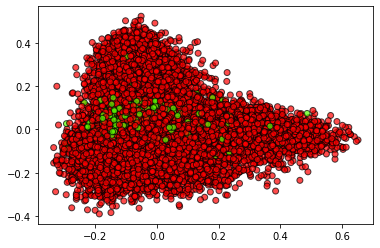

Precision score 0.8043230944254836
Recall score 0.7952755905511811
F1-score score 0.7997737556561088
Accuracy score 0.9703343668817564


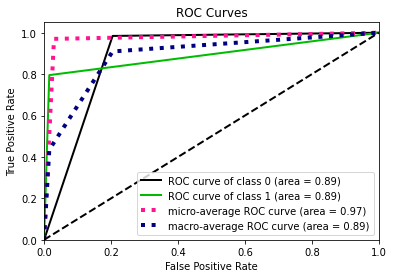

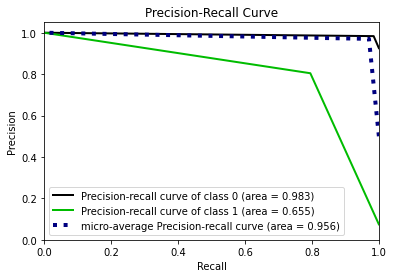

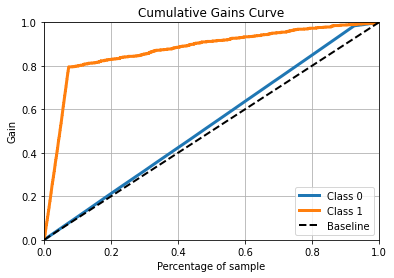

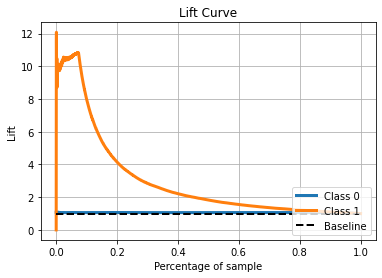

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11044
           1       0.80      0.80      0.80       889

    accuracy                           0.97     11933
   macro avg       0.89      0.89      0.89     11933
weighted avg       0.97      0.97      0.97     11933



In [70]:
roc_auc_imb,fpr_imb,tpr_imb, _ = build_and_test(X_train, X_test, y_train, y_test)

# Oversample the smallest class

Oversampling is a technique which increases the number of samples of the smallest class up to the size of the biggest class. This is done by generating synthetic samples. Different techniques can be applied to oversample a class. In this tutorial I will use `RandomOverSampler` and `SMOTE`. The `imbalanced-learn` package also provides other techniques, such as ADASYN and Rose.
All the over samplers provide a function, called `fit_resemple()`, which receives the `X_train` input variable and the `y_train` output variable and return the over sampled input and output variables, respectively `X_res` and `y_res`.

In [71]:
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train, y_train)
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 25727, 1: 25727})
Testing target statistics: Counter({0: 11044, 1: 889})


`X_res` and `y_res` can be provided as parameters of the `build_and_test()` function. From the PCA plot, I note that the number of green points have increased incredibly. 

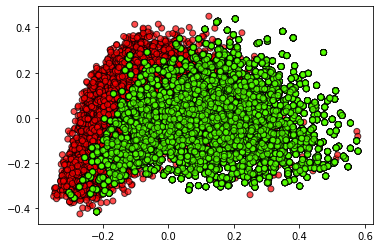

Precision score 0.7541713014460512
Recall score 0.7626546681664792
F1-score score 0.7583892617449665
Accuracy score 0.9637978714489231


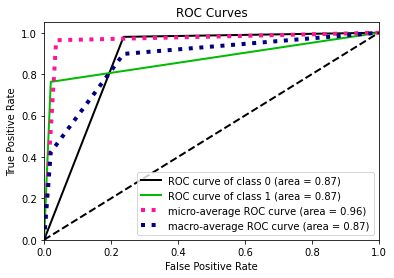

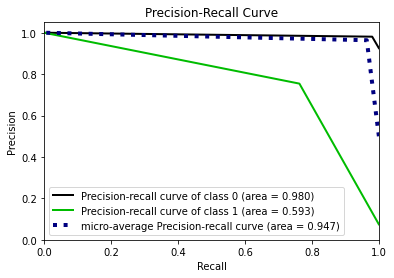

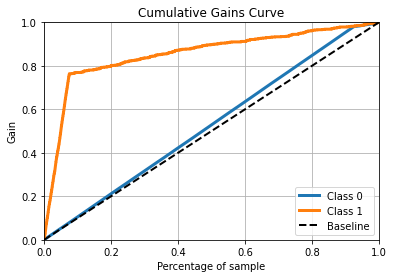

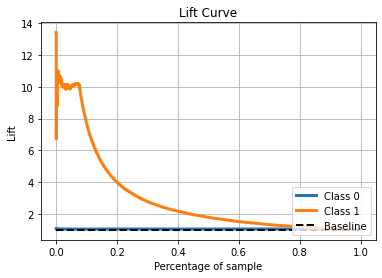

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11044
           1       0.75      0.76      0.76       889

    accuracy                           0.96     11933
   macro avg       0.87      0.87      0.87     11933
weighted avg       0.96      0.96      0.96     11933



In [72]:
roc_auc_ros,fpr_ros,tpr_ros, _ = build_and_test(X_res, X_test, y_res, y_test)

The same analysis can be done for the `SMOTE` technique.

In [73]:
from imblearn.over_sampling import SMOTE
over_sampler = SMOTE(k_neighbors=2)
X_res, y_res = over_sampler.fit_resample(X_train, y_train)
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 25727, 1: 25727})
Testing target statistics: Counter({0: 11044, 1: 889})


Similarly to the `RandomOverSampler`, from the PCA plot I note the size of the green points. With respect to the `RandomOverSampler`, the distribution of the green points is quite different.

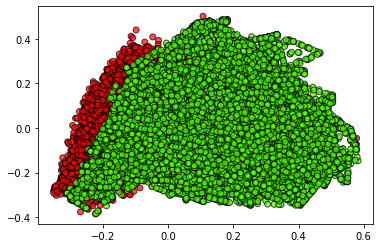

Precision score 0.7471736896197327
Recall score 0.8177727784026997
F1-score score 0.7808807733619765
Accuracy score 0.9658091008128719


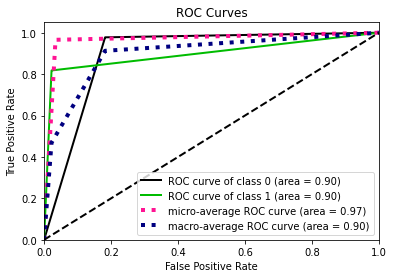

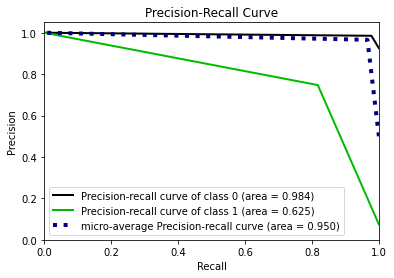

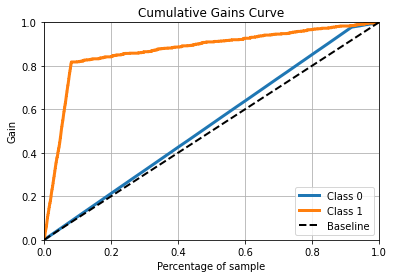

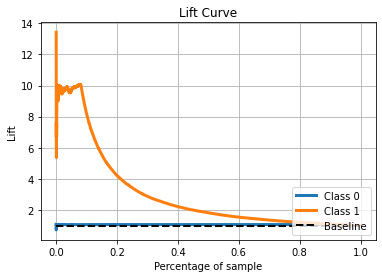

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     11044
           1       0.75      0.82      0.78       889

    accuracy                           0.97     11933
   macro avg       0.87      0.90      0.88     11933
weighted avg       0.97      0.97      0.97     11933



In [74]:
roc_auc_smote,fpr_smote,tpr_smote, _  = build_and_test(X_res, X_test, y_res, y_test)

# Undersample the biggest dataset
Undersampling is a technique which decreases the number of samples of the biggest class down to the size of the smallest class. This is done by removing some samplers from the biggest class.
Different techniques can be applied to undersample a class. In this tutorial I will use `RandomUnderSampler` and `NearMiss`. The `imbalanced-learn` package also provides other techniques, such as Condensed Nearest Neighbour.
Similarly to over samplers, all the under samplers provide a function, called `fit_resemple()`, which receives the `X_train` input variable and the `y_train` output variable and return the under sampled input and output variables, respectively `X_res` and `y_res`.

In [75]:
from imblearn.under_sampling import RandomUnderSampler

under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(X_train, y_train)
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 2114, 1: 2114})
Testing target statistics: Counter({0: 11044, 1: 889})


Once undersampled the dataset, I call the `build_and_test()` function. From the PCA plot, I note that the number of red points has reduced.

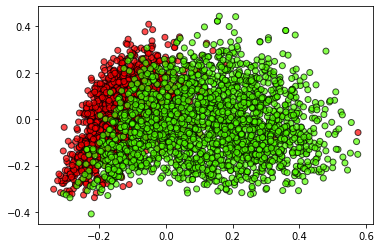

Precision score 0.47574517825832846
Recall score 0.9156355455568054
F1-score score 0.6261538461538462
Accuracy score 0.9185452107600771


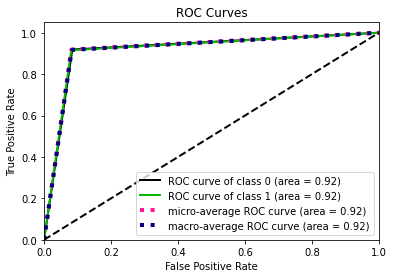

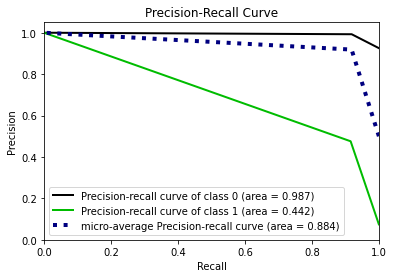

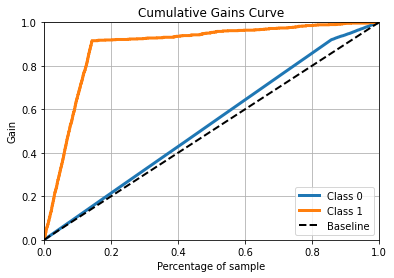

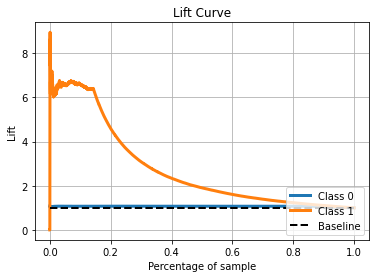

              precision    recall  f1-score   support

           0       0.99      0.92      0.95     11044
           1       0.48      0.92      0.63       889

    accuracy                           0.92     11933
   macro avg       0.73      0.92      0.79     11933
weighted avg       0.95      0.92      0.93     11933



In [76]:
roc_auc_rus,fpr_rus,tpr_rus , _ = build_and_test(X_res, X_test, y_res, y_test)

The same analysis can be done for the `NearMiss` under sampler.

In [83]:
from imblearn.under_sampling import NearMiss

under_sampler = NearMiss()
X_res, y_res = under_sampler.fit_resample(X_train, y_train)
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 2114, 1: 2114})
Testing target statistics: Counter({0: 11044, 1: 889})


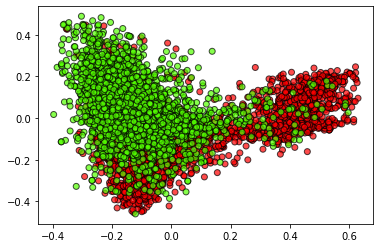

Precision score 0.4359861591695502
Recall score 0.8503937007874016
F1-score score 0.5764391917651545
Accuracy score 0.9068968406938741


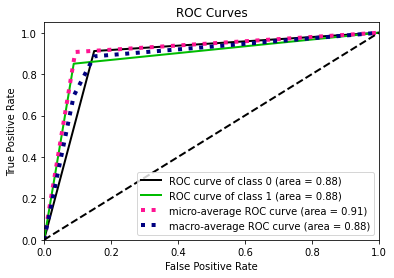

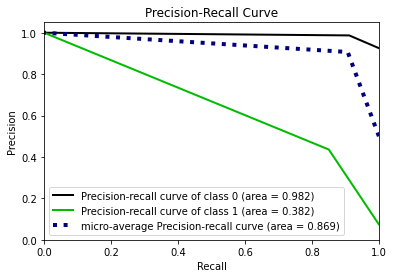

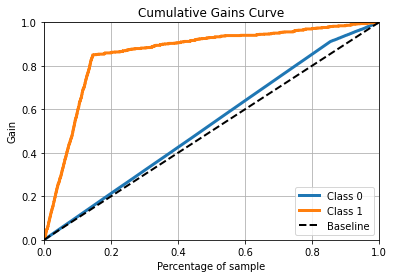

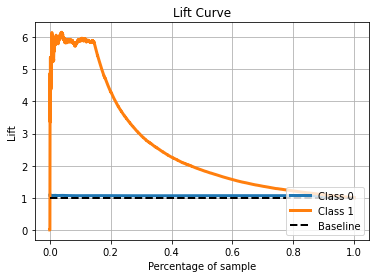

              precision    recall  f1-score   support

           0       0.99      0.91      0.95     11044
           1       0.44      0.85      0.58       889

    accuracy                           0.91     11933
   macro avg       0.71      0.88      0.76     11933
weighted avg       0.95      0.91      0.92     11933



In [78]:
roc_auc_nm,fpr_nm,tpr_nm, _  = build_and_test(X_res, X_test, y_res, y_test)

# Class Weight
Setting the class weight constitutes another valid alternative for balancing. Each `scikit-learn` classification model can be configured with a parameter, called `class_weight`, which receives the weight of each class in the form of a Python dictionary. 
In order to calculate the weight of each class, I can set the weight of the biggest class to 1 and set the weight of the smallest class to the ratio between the number of samples of the biggest class and the number of samples of the smallest class.

In [79]:
n= Counter(y_train)
ratio = int(n[0]/n[1])
ratio, n

(12, Counter({0: 25727, 1: 2114}))

I call the `build_and_test()` function by setting the `class_weight` parameter.

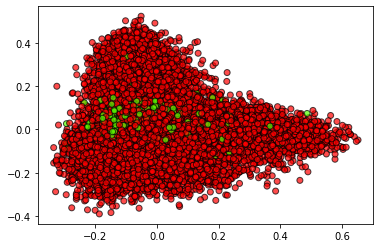

Precision score 0.7311827956989247
Recall score 0.7649043869516311
F1-score score 0.7476635514018694
Accuracy score 0.9615352384144809


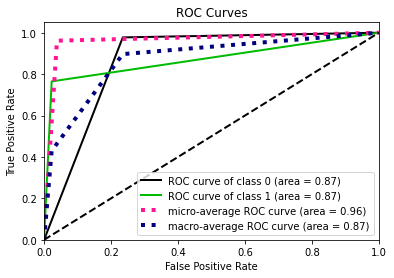

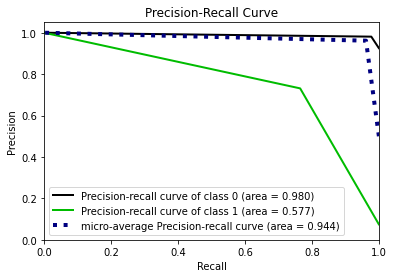

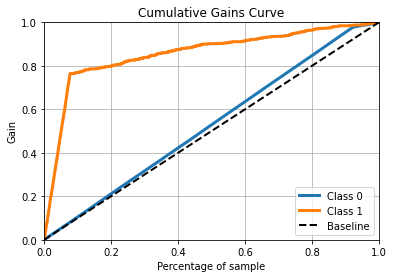

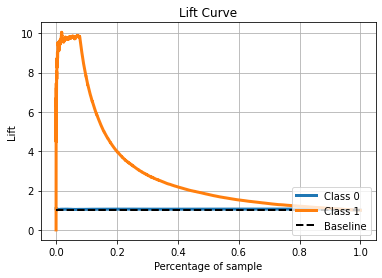

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11044
           1       0.73      0.76      0.75       889

    accuracy                           0.96     11933
   macro avg       0.86      0.87      0.86     11933
weighted avg       0.96      0.96      0.96     11933



In [80]:
roc_auc_cw,fpr_cw,tpr_cw, _  = build_and_test(X_train, X_test, y_train, y_test, class_weight={0:1, 1:ratio})

# Threshold
Adjusting threshold is a manual technique to balance a dataset. Conceptually, if a predicted value is greater than the threshold, it is set 1, otherwise it is set to 0. More details regarding thresholds can be found at [this link](https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/).
In this tutorial I will set the value of the threshold to the value which maximizes the [Youden’s J statistic](https://en.wikipedia.org/wiki/Youden%27s_J_statistic). In addition, I will extract the list of candidate thresholds from the `roc_curve()`

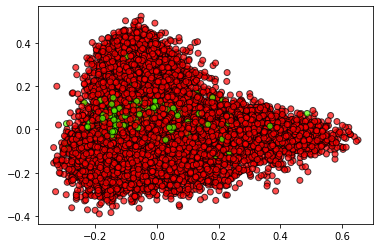

Precision score 0.8064146620847652
Recall score 0.7919010123734533
F1-score score 0.7990919409761634
Accuracy score 0.9703343668817564


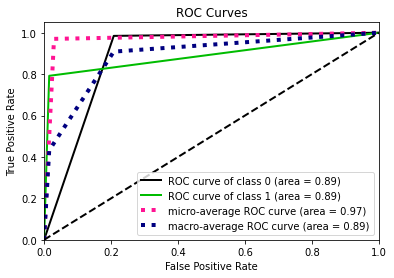

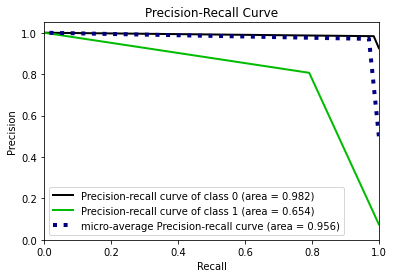

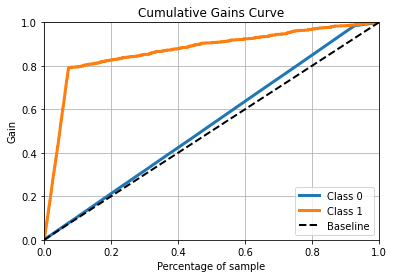

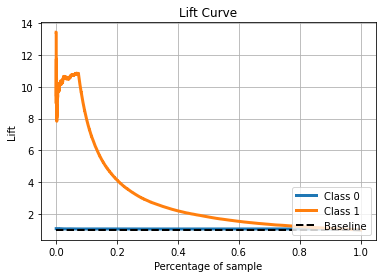

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11044
           1       0.81      0.79      0.80       889

    accuracy                           0.97     11933
   macro avg       0.89      0.89      0.89     11933
weighted avg       0.97      0.97      0.97     11933

Best Treshold: 1.0


In [81]:
roc_auc_thr,fpr_thr,tpr_thr, threshold = build_and_test(X_train, X_test, y_train, y_test, threshold=True)
print(f"Best Treshold: {threshold}")

# Plot all together
Finally, I plot all the ROC curves together. I note that in my case the best technique is the Random Under Sampler, with the greatest value of AUC.

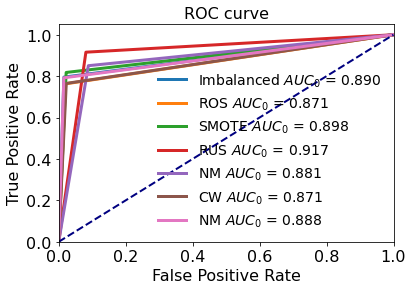

In [82]:
plt.plot(fpr_imb, tpr_imb, lw=3, label='Imbalanced $AUC_0$ = %.3f' % (roc_auc_imb))
plt.plot(fpr_ros, tpr_ros, lw=3, label='ROS $AUC_0$ = %.3f' % (roc_auc_ros))
plt.plot(fpr_smote, tpr_smote, lw=3, label='SMOTE $AUC_0$ = %.3f' % (roc_auc_smote))
plt.plot(fpr_rus, tpr_rus, lw=3, label='RUS $AUC_0$ = %.3f' % (roc_auc_rus))
plt.plot(fpr_nm, tpr_nm, lw=3, label='NM $AUC_0$ = %.3f' % (roc_auc_nm))
plt.plot(fpr_cw, tpr_cw, lw=3, label='CW $AUC_0$ = %.3f' % (roc_auc_cw))
plt.plot(fpr_thr, tpr_thr, lw=3, label='NM $AUC_0$ = %.3f' % (roc_auc_thr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()